<a href="https://colab.research.google.com/github/dylan33smith/HistopathologicCancerDetection/blob/main/KaggleDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Histopathologic Cancer Detection**
Dylan Smith <br>
CSPB 3202: Fall 2023 <br>
Homework 5: Kaggle Competition <br>
Github URL: https://github.com/dylan33smith/HistopathologicCancerDetection


## **Problem**

The purpose of this competition is to create an algorithm that accurately identifies cancer in small image patches taken from pathology scans. This is a binary classification task, as we are aiming to identify either the presence of cancer (1) or the absence of cancer (0).

The evaluation metric for this challenge is the ROC curve measuring the performance of the prediction models based on their accuracy in distinguishing between the presence of cancerous tissue or the absence of cancerous tissue.

## **Data**

The data used in this challenge is a cleaned (no duplicates) version of the PatchCamelyon benchmark data set. The data is split into two directories, train and test. Test contains 57458 .tif images while Train contains 220,025 .tif images. In addition to the training images, train_labels.csv contains a positive or negative label corresponding to each of the images in the Train folder.

The labels for the training data correspond to the 32x32 pixel section in the center of each image. A positive label indicates that this 32x32 pixel region contains at least one pixel of tumor. The pixels from outside of this region do not influence the label, and so any tumor containing pixels in this region will not contribute to a positive label.

<br>
<br>


## **Downloading data from Kaggle and preparing Collab environment**

In [1]:
from google.colab import files


In [ ]:
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [01:15<00:00, 140MB/s]
100% 6.31G/6.31G [01:15<00:00, 89.7MB/s]


In [11]:
import zipfile

In [12]:
with zipfile.ZipFile('/content/histopathologic-cancer-detection.zip','r') as zip_ref:
  zip_ref.extractall('content/histopathologic_dataset')

# (1m 43s)

In [ ]:
!pip install h5py

In [ ]:
!pip install pandas
!pip install numpy==1.24.3
!pip install scikit-learn

In [ ]:
!pip install tensorflow


## **Exploratory Data Analysis**


In [1]:
import os
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam

import h5py

In [2]:
train_df = pd.read_csv('./content/histopathologic_dataset/train_labels.csv')
# This is a df of the image id and it's associated pos/neg label (for training images)
train_df.head()
# shape: (220025, 2)
# labels are given in binary with 0 corresponding to non-cancerous and 1 corresponding to cancerous

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
# path to directory containing training images
train_dir = './content/histopathologic_dataset/train/'


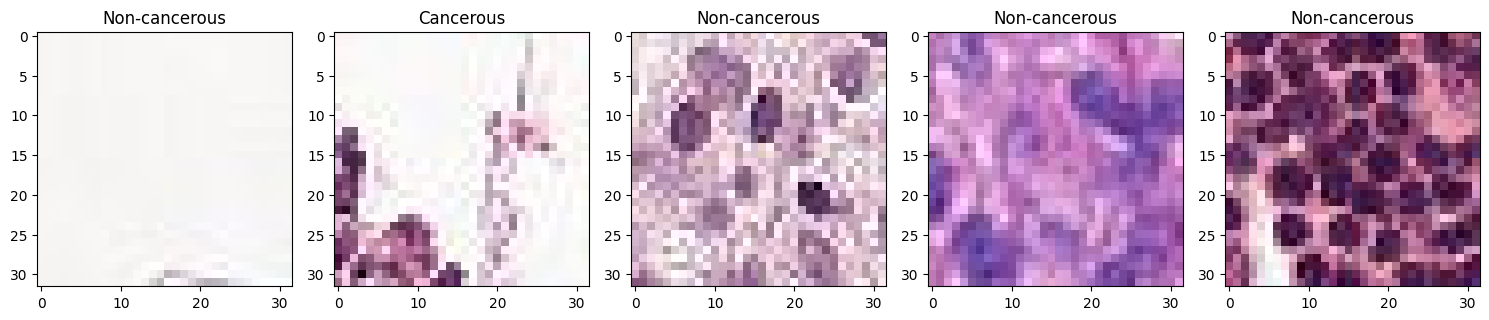

In [4]:
# Sample of training images
  # includes only the 32x32 region on which the label is based
train_head = train_df.head(5)

plt.figure(figsize=(15, 3))
for i, row in enumerate(train_head.iterrows()):
    img_id, label = row[1]
    img_path = train_dir + f'{img_id}.tif'
    img = Image.open(img_path)
    # crop center 32x32
    img = img.crop((32, 32, 64, 64))

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    if label == 0:
        plt.title("Non-cancerous")
    else:
        plt.title("Cancerous")

plt.tight_layout()
plt.show()

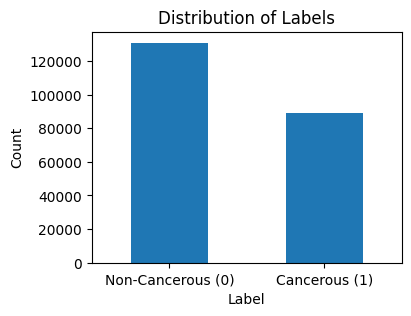

In [5]:
# see distribution of label values in the training data

label_count = train_df['label'].value_counts()
plt.figure(figsize=(4, 3))
label_count.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Cancerous (0)', 'Cancerous (1)'], rotation=0)
plt.show()

From the above plot, we can see that there are only values of 0 and 1 (no NULL) for labels in the data. We will assume that the data is clean and no samples should be excluded.

In [6]:
c_perc = (label_count[0] / (label_count[0] + label_count[1]))
nc_perc = (label_count[1] / (label_count[0] + label_count[1]))
ratio = label_count[0] / label_count[1]

print(f"non-cancerous: {label_count[0]}, {c_perc*100:9.2f}%")
print(f"cancerous: {label_count[1]},  {nc_perc*100:9.2f}%")
print(f"Class Imbalance: {ratio:9.2f}")

non-cancerous: 130908,     59.50%
cancerous: 89117,      40.50%
Class Imbalance:      1.47


From the above plot and ratio, we can see that there is a substantial imbalance between cancerous and non-cancerous images, with almost 1.5 times as many non-cancerous samples as cancerous. In order to address this, non-cancerous images will be undersampled so there are equal amounts of each. This will still leave a substantial amount of data so the tradeoff between data-loss and skew is reasonable.

In [7]:
# seperate into cancerous and non-cancerous
train_cancer = train_df[train_df['label'] == 1]
train_non_cancer = train_df[train_df['label'] == 0]

# randomly sample non-cancerous samples to match number of cancerous
train_non_cancer_under = train_non_cancer.sample(n=len(train_cancer['label']), random_state = 33)

# sanity check
print(train_non_cancer_under.shape)
print(train_cancer.shape)

(89117, 2)
(89117, 2)


From the shape of the two data sets, we can see that non-cancerous images have been accurately sampled to match the sample size of cancerous images.

In [8]:
# combine cancerous with undersampled non-cancerous to provide new training dataset
train_dataset = pd.concat([train_cancer, train_non_cancer_under])

# sanity check
print(f"Total number of samples: {len(train_dataset)}")
print(train_dataset['label'].value_counts())

Total number of samples: 178234
1    89117
0    89117
Name: label, dtype: int64


The above block of code shows us that our training data now contains 178,234 images and labels with an even number of cancerous and non-cancerous.

## **Image Processing Section**

Neural Networks perform mathematical operation (multiplication, addition and activation functions), so input data has to be given in numerical form. In order to convert the given image data into a numerical representation suitable for use in CNN's, the 32x32 pixel center of each pixel will be extracted and the corresponding rgb values will be normalized to values between 0 and 1.

The resulting data will be (178234, 32, 32, 3) which requires a lot of storage. When converting the image data, I kept running out of compute and crashing the Collab notebook, so I extracted the data into an hdf5 file so that it was stored on disk rather than RAM. This made it so that I didn't have to load the whole of the data at once, and could instead load only the split training and testing data further on. I further saved the data as float32 dtype rather than the conventional float64 as I kept running into issues with the amount of RAM I had access to.  

In [9]:
###### don't run!! takes a long time ############
# check all images are same size
    # removes calculations in get_images cropping of center pixels
    # only tissue in center 32x32 patch influences label
# for path in train_img_paths:
    # img = Image.open(path)
    # if img.size != (96, 96):
      # print("not all same size")
      # break

In [10]:
def save_images_to_hdf5(img_ids, hdf5_path, dataset_name):
    '''
    Uses the image id's to identify each image file and then saves the processed image data to an hdf5 file (disk storage)
        Resize to only include center 32x32 pixels (from 96x96 of original).
        Scale pixel values to range between 0 and 1.

    Parameters:
    img_ids: List of image IDs mapping to image files.
    hdf5_path: Path to save the HDF5 file.
    dataset_name: Name of the dataset in the HDF5 file.
    '''

    # Calculate the number of images
    num_images = len(img_ids)

    # Create a new HDF5 file
    with h5py.File(hdf5_path, "w") as hf:
        # Create a dataset in the file to hold all the images
        dataset = hf.create_dataset(f'{dataset_name}', (num_images, 32, 32, 3), np.float32)

        for i, img_id in enumerate(img_ids):
            img_path = os.path.join(train_dir, img_id + '.tif')
            img = Image.open(img_path)

            # Crop center 32 pixels
            img = img.crop((32, 32, 64, 64))  # left, upper, right, lower pixel coordinates

            # normalize rgb values
            img_arr = np.array(img) / 255.0

            # store the image in the dataset
            dataset[i, ...] = img_arr



In [11]:
def load_images_from_hdf5(hdf5_path, dataset_name, indices):
    '''
    Load images from an HDF5 file based on indice.
        Indices will be needed later on to identify image arrays based on train/test split

    Parameters:
    hdf5_path: Path to the hdf5 file.
    dataset_name: Name of the dataset in the hdf5 file.
    indices: list of indices to extract from hdf5

    '''
    with h5py.File(hdf5_path, "r") as hf:
        images = np.empty((len(indices), 32, 32, 3))
        for i, idx in enumerate(indices):
            images[i] = hf[dataset_name][idx]

    return images

In [12]:
# get the path to each of the images in the balanced dataset
train_ids = train_dataset['id'].values

In [35]:
# only have to run once to save hdf5 file
# save_images_to_hdf5(train_ids, './content/training_images.h5', 'processed_images')
# 4m 12s

To get images, use:
- load_images_from_hdf5('./content/training_images.h5', 'processed_images', indices)

This will be used to get the training and testing images by their indice after train_test_split has been used. Avoids having to load the whole dataset into memory on top of the training and testing datasets.

# **Model Architecture**

The architecture for my model will be a linear stack of layers made using Keras Sequential model. This allows you to add layers layer-by-layer to the model. The model will be relatively simple with 7 total layers.

**Convolutional Layers** <br>
Convolutional layers are used to extract features from the input data. The first convolutional layer directly processes the raw input image (input_shape = (32, 32, 3)) and extracts and learns simple features within the image including things like vertical edges, horizontal edges, textures, etc. The second convolutional layer works on the features extracted by the first conv layer in order to detect higher-level features like shapes and patterns. The larger number of filters in this layer allows the network to learn more of these more complex features.

**MaxPooling Layers** <br>
Max Pooling layers are used to reduce the dimensions of the input volume (feature maps from convolutional layers in this case) . They take the max value over a window (2,2) in order to bring out features and remove less informative details. This decreases the the computational load for the network and reduces the number of parameters in the model which helps prevent overfitting.

**Flatten Layer**<br>
The flatten layer is used to transform the multidimensional output of the previous layer to a 1D array. This is necessary because the next layer is a Dense layer which requires an 1D input.

**Dense Layer**<br>
Dense layers are fully connected layers which means that each neuron in this layer recieves input from all the neurons in the previous (flattened) layer. This acts to combine features extracted in earlier layers in order to recognize more complex layers. The final layer in the model is a dense layer with a single neuron which (along with the sigmoid activation function) condenses the models learning down into a probability.


**Activation Functions**
- **Relu**<br>
  - f(x) = max(0, x)
  - This is a linear function that outputs the input directly if it is positive and otherwise outputs 0.
  - Computationally efficient

- **Sigmoid** <br>
  - f(x) = 1 / (1 + exp(-x))
  - This outputs a value between 0 and 1 which makes it ideal for binary classification.
  - This is used in the final dense layer to condense all the models previous learning down into a number between 0 and 1 which is taken to correspond to a probability.

  <br>
  <br>
  Split the data into training and testing

In [13]:
# get just the pos/neg labels from train_df
train_labels = train_dataset['label'].values

In [14]:
# sanity check
print(train_labels.shape)
print(type(train_labels))

(178234,)
<class 'numpy.ndarray'>


In [15]:
# seperate data into training and validation
training_indices, testing_indices, training_labels, testing_labels = train_test_split(
    range(len(train_labels)),
    train_labels,
    test_size = 0.2,
    random_state = 33
)

A list corresponding to indices is used as the feature vector to split in the above train_test_split function, as that will allow us to extract the image data directly from our hdf5 file.

In [16]:
training_images = load_images_from_hdf5('./content/training_images.h5', 'processed_images', training_indices)
testing_images = load_images_from_hdf5('./content/training_images.h5', 'processed_images', testing_indices)

# (54s)
# 4 GB RAM
# garbage collect these after model is trained on them to save up RAM

In [17]:
# sanity check
print(training_images.shape)
print(testing_images.shape)
print(training_labels.shape)
print(testing_labels.shape)

(142587, 32, 32, 3)
(35647, 32, 32, 3)
(142587,)
(35647,)


The above block shows that our training and testing images are the correct size and that their labels match them in size.

## **Model**





In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)), # pooling in between conv layers consolidates extracted features
    Conv2D(64, (3, 3), activation='relu'), # more filters alows for more complex patterns to be extracted than in first layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

In [19]:
# optimizer is responsible for adjusting the weights of the network during training to minimize loss function
# binary_crossentropy is used as the loss function and measures the 'distance' between the predicted P and the actual labels
# use accuracy metric to evaluate training
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(training_images, training_labels, epochs=10,
                    validation_data=(testing_images, testing_labels))

Epoch 1/10
4456/4456 [==============================] - 117s 26ms/step - loss: 0.5079 - accuracy: 0.7584 - val_loss: 0.4816 - val_accuracy: 0.7787
Epoch 2/10
4456/4456 [==============================] - 110s 25ms/step - loss: 0.4682 - accuracy: 0.7839 - val_loss: 0.4519 - val_accuracy: 0.7929
Epoch 3/10
4456/4456 [==============================] - 113s 25ms/step - loss: 0.4515 - accuracy: 0.7936 - val_loss: 0.4767 - val_accuracy: 0.7811
Epoch 4/10
4456/4456 [==============================] - 112s 25ms/step - loss: 0.4400 - accuracy: 0.8007 - val_loss: 0.4379 - val_accuracy: 0.8002
Epoch 5/10
4456/4456 [==============================] - 110s 25ms/step - loss: 0.4294 - accuracy: 0.8060 - val_loss: 0.4657 - val_accuracy: 0.7824
Epoch 6/10
4456/4456 [==============================] - 117s 26ms/step - loss: 0.4212 - accuracy: 0.8090 - val_loss: 0.4289 - val_accuracy: 0.8065
Epoch 7/10
4456/4456 [==============================] - 114s 26ms/step - loss: 0.4150 - accuracy: 0.8131 - val_loss: 0

(18m 2s)

## **Model Results**

The previous method (history=model.fit) returns a history object which contains data about the training process through each epoch. Our object records the training and validation loss which can be plotted to check for overfitting. It also records accuracy (defined when compiling model) which can be plotted to show how the model prediction improves across epohs.

In [21]:
# Extracting loss, training accuracy, and validation accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

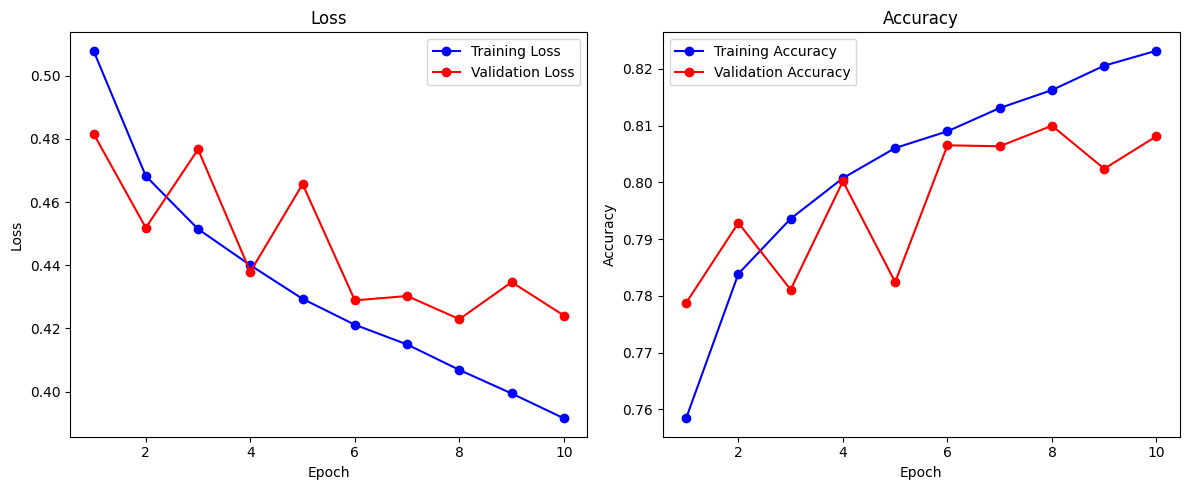

In [58]:
# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The graph on the left shows the loss during the models training. The training loss (blue) is decreasing consistently which indicates that the model is learning. The validation loss (red) is less smooth which shows that the models performance on unseen data is inconsistent.

The graph on the right shows the accuracy (percentage of correct predictions in the training set) of the models training across epochs. The training accuracy (blue) has a smooth upward trend which shows that the model is improving at classifying the training data. The validation accuracy (red) shows a general upward trend, but with significant variability which indicates that the model isn't improving on unseen data as consistently.

Overall the model doesn't seem to indicate overfitting yet, as the validation loss is generally decreasing and and the validation accuracy is generally increasing (although with significant fluctuations indicating poor classifying performance). Overfitting would be indicated if the validation losss started to increase as the training loss continued to decrease which doesn't seem to be happening (although the validation loss does seem to be leveling out in the further epochs).

## **Model Classification on Test images**

In [26]:
# Training complete. clean up space in RAM
import gc

del training_images
del testing_images

gc.collect()

11803

In [29]:
del train_cancer
del train_dataset
del train_df
del train_dir
del train_head
del train_ids
del train_labels
del train_non_cancer
del train_non_cancer_under
del train_test_split

gc.collect()

768

In [27]:
def save_test_images_to_hdf5(test_dir, hdf5_path, dataset_name):
    '''
    Save image data from all of the images in training folder to an HDF5 file.
    Resize to only include center 32x32 pixels (from 96x96 of original).
    Scale pixel values to range between 0 and 1.

    Parameters:
    test_dir: path to directory containing testing images
    hdf5_path: Path to save the HDF5 file.
    dataset_name: Name of the dataset in the HDF5 file.
    '''

    with h5py.File(hdf5_path, 'w') as hf:
      # get images from test directory
      img_files = [image for image in os.listdir(test_dir) if image.endswith('.tif')]

      dataset = hf.create_dataset(f'{dataset_name}', (len(img_files), 32, 32, 3), np.float32)

      for i, file in enumerate(img_files):
        img_path = os.path.join(test_dir, file)
        img = Image.open(img_path)

      # crop center 32x32 pixels
      img = img.crop((32, 32, 64, 64))

      # normalize
      img_arr = np.array(img) / 255.0

      # store image in dataset
      dataset[i, ...] = img_arr

In [38]:
def load_test_images_from_hdf5(hdf5_path, dataset_name):
    '''
    Load images from an HDF5 file based on indice.

    Parameters:
    hdf5_path: Path to the hdf5 file.
    dataset_name: Name of the dataset in the hdf5 file.
    indices: list of indices to extract from hdf5

    '''
    with h5py.File(hdf5_path, "r") as hf:

        images = hf[dataset_name][:]

    return images

In [28]:
test_dir = './content/histopathologic_dataset/test'

# save hdf5 file --> only need to run once
# save_images_to_hdf5(train_ids, './content/training_images.h5', 'processed_images')
# save_test_images_to_hdf5(test_dir, './content/testing_images.h5', 'processed_images')
# (1m 2s)

In [39]:
test_images = load_test_images_from_hdf5('./content/testing_images.h5', 'processed_images')

In [40]:
test_images.shape

(57458, 32, 32, 3)

In [43]:
# label prediction on test images
predictions = model.predict(test_images)

1796/1796 [==============================] - 16s 9ms/step


In [48]:
# convert the prediction to binary 0 or 1 to map to non-cancerous or cancerous respectively
# the models predictions will be between 0 and 1 (due to final sigmoid layer) corresponding to probabilities
# convert predictions to true/flase binary
tf_predictions = (predictions > 0.5).astype(int).flatten()

In [50]:
# extract image IDs for uploading to kaggle
test_img_ids = [os.path.splitext(file)[0] for file in os.listdir(test_dir) if file.endswith('.tif')]

In [56]:
# sanity check. images correspond to predictions
print(len(test_img_ids))
print(len(predictions))

57458
57458


In [53]:
# put test predictions into correct format (id, label)
final = pd.DataFrame({
    'id': test_img_ids,
    'label': tf_predictions
})

In [54]:
# save final results to .csv
final.to_csv('/content/model_results.csv', index=False)

# Results and Analysis



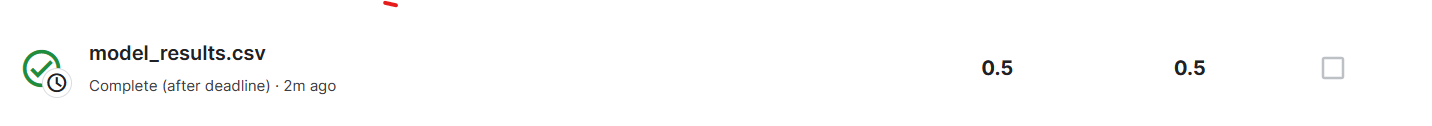

In [69]:
vals, counts = np.unique(predictions, return_counts=True)
print(vals, counts)

[0.04668562 0.20115809 0.20115814] [    1  3590 53867]


Results from the submission of the model can be seen above. From the score of 0.5, we can see that something went wrong with the model. From looking at the values of the predictions in the following block, we can see that our model predicted every image as having a probability less than .5. When these probabilites are converted to binary classification (0 if < .5 and 1 if > .5), the result is that our model predicts that each image is non-cancerous. From the results of the kaggle submission, we can see that the model is tested on an even split of images and so every cancer containing image was miss-classified as being non-cancerous. This is the case even with undersampling of the non-cancerous images, the inclusion of which would likely have made our model predict even lower probabilities.

In general this indicates that our model is effectively useless in this classification task. The variability in the validation loss and accuracy during training shows that this is likely due to the structure of our model, perhaps as a result of it's simplicity. Even after undersampling the non-cancerous images, the size of the training dataset was still large so it is unlikely that the models poor performance was due to lack of sufficient data. By not including padding in our image data, the reduction of the size of feature maps in each layer due to convolution and pooling could have meant that our feature map became too small to be passed on to further layers. This would lead to loss of information and posssibly an inability to use further layers although this is unlikely as our model still improved through each epoch.

**Possible Improvements**

As mentioned above, adding padding (0s) during image processing could have improved our models ability to pick up spatial features. With the compute limit I had and the frequent crashes, I was wary of increasing the size of that data set though, so this was not implemented.

An improvement that likely would have increased the models performance was increasing the depth of layers. These images are complex, so adding convolutional layers could help the model learn more complex patterns, although it could also lead to overfitting. Due to time constraints, I didn't have a chance to add more layers to the model. Something I would like to try in the future is to build multiple models each with a different number of convolutional layers and perhaps kernals as well as kernal size to see if an optimal model configuration could be found.

Another improvement that could have been implemented is using a different activation function such as ELU. It is possible that my model was influenced by the dying ReLu problem so that the an input to a neuron always resulted in the same output. The small number of predicted probabilities (3) could indicate that this happened (?) and so the output was only influence by some small number of inputs. Using a different activation function could help with this problem but we are once again limited by the limited compute in the Collab environment.



**Conclusion**<br>
Although my model was essentially useless in this classification task, the possibilities for further improvements means that this model could be used to learn the effects of each improvement. This model was incredibly simple as far as CNNs go, so it provides a good foundation from which to learn how each aspect of improving a model impacts the CNN as a whole.

While the end result of my model was dissapointing, I learned more in this project than I expected and more than I have from many other assignements. This was my first foray into using tensorflow, using google.colabs and working with CNNs. Even setting up the environment the environment and downloading the data using Kaggles API caused a lot of problems, but also taught me a lot in struggling with them. I frequently reached the limits of available computing but learned a method for storing data on the disk rather than in RAM (hdf5).
Setting up the model and working to understand each aspect of it gave me a solid foundation to improve my machine learning capabilities and to work on more complex and autonomous ML problems.

**References**<br>
https://github.com/CameronStockton/histopathologic-cancer-detection